In [62]:
import awkward as awk
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
plt.style.use('figures.mplstyle')
import numpy as np

In [67]:
filename = {"MINERvA":"MINERvA_Dipole_M4.70e-01_mu1.25e-06_example.parquet",
            "MiniBooNE":"MiniBooNE_Dipole_M4.70e-01_mu1.25e-06_example.parquet",
            "CCM":"CCM_Dipole_M2.35e-02_mu3.00e-07_example.parquet"}

POT = {"MINERvA":11.6e20,
       "MiniBooNE":18.75e20,
       "CCM":2.25e22}

Emax = {"MINERvA":20,
        "MiniBooNE":3,
        "CCM":0.04}

axis = {"MINERvA":3,
        "MiniBooNE":3,
        "CCM":1}

xrange = {"MINERvA":[-2,2],
          "MiniBooNE":[-8,8],
          "CCM":[-5,25]}

yrange = {"MINERvA":[-2,2],
          "MiniBooNE":[-8,8],
          "CCM":[-3,3]}

zrange = {"MINERvA":[-10,10],
          "MiniBooNE":[-10,10],
          "CCM":[-3,3]}


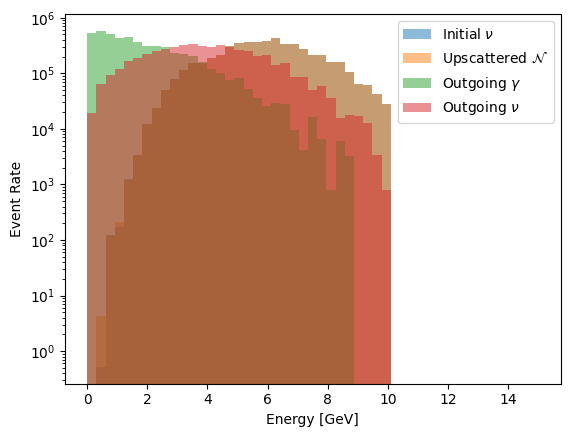

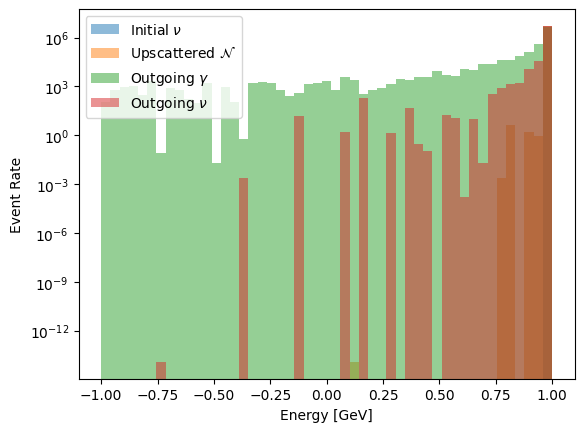

In [142]:
# Kinematic distributions

def plot_kinematics(data,POT,Emax,axis):
    
    fig,ax = plt.subplots(2,1,figsize=(8,12))
    ax[0].set_prop_cycle(color=['red', 'green', 'blue', 'orange'])
    ax[1].set_prop_cycle(color=['red', 'green', 'blue', 'orange'])
    
    dec_flag = data["primary_type"]=="ParticleType.N4"
    fid_flag = data["in_fiducial"][dec_flag]
    
    # initial nu
    nu_flag = data["primary_type"]=="ParticleType.NuMu"
    nu_momenta = np.squeeze(data["primary_momentum"][nu_flag])

    # N
    N_flag = data["primary_type"]=="ParticleType.N4"
    N_momenta = np.squeeze(data["primary_momentum"][N_flag])

    # gamma
    gamma_flag = data["secondary_types"]=='ParticleType.Gamma'
    gamma_momenta = data["secondary_momenta"][gamma_flag]
    # mask out entries that are not gamma
    gamma_momenta = awk.mask(gamma_momenta, awk.num(gamma_momenta,axis=2)>0)
    gamma_momenta = np.squeeze(gamma_momenta[~awk.is_none(gamma_momenta,axis=1)])

    # nu out
    nuout_flag = data["secondary_types"]=='ParticleType.NuLight'
    nuout_momenta = data["secondary_momenta"][nuout_flag]
    # mask out entries that are not nuout
    nuout_momenta = awk.mask(nuout_momenta, awk.num(nuout_momenta,axis=2)>0)
    nuout_momenta = np.squeeze(nuout_momenta[~awk.is_none(nuout_momenta,axis=1)])

    kwargs = {"bins":np.linspace(0,Emax,50),
              "weights":data["event_weight"]*POT,
              "histtype":"step"}

    # Energy
    n,_,_ = ax[0].hist(nu_momenta[:,0],**kwargs,label=r"Initial $\nu$")
    ax[0].hist(N_momenta[:,0],**kwargs,label=r"Upscattered $\mathcal{N}$")
    ax[0].hist(gamma_momenta[:,0],**kwargs,label=r"Outgoing $\gamma$")
    ax[0].hist(nuout_momenta[:,0],**kwargs,label=r"Outgoing $\nu$")
    
    # Angle
    def CosTheta(momenta):
        return momenta[:,axis]/np.linalg.norm(momenta[:,1:],axis=-1)
    
    kwargs["bins"] = np.linspace(0,1,50)
    
    m,_,_ = ax[1].hist(CosTheta(nu_momenta),**kwargs,label=r"Initial $\nu$")
    ax[1].hist(CosTheta(N_momenta),**kwargs,label=r"Upscattered $\mathcal{N}$")
    ax[1].hist(CosTheta(gamma_momenta),**kwargs,label=r"Outgoing $\gamma$")
    ax[1].hist(CosTheta(nuout_momenta),**kwargs,label=r"Outgoing $\nu$")
    
    # fiducial events
    
    kwargs["ls"] = "--"
    kwargs["weights"]=kwargs["weights"]*fid_flag
    kwargs["bins"] = np.linspace(0,Emax,50)
    
    # Energy [fiducial]
    ax[0].hist(nu_momenta[:,0],**kwargs)
    ax[0].hist(N_momenta[:,0],**kwargs)
    ax[0].hist(gamma_momenta[:,0],**kwargs)
    ax[0].hist(nuout_momenta[:,0],**kwargs)
    
    kwargs["bins"] = np.linspace(0,1,50)
    
    ax[1].hist(CosTheta(nu_momenta),**kwargs)
    ax[1].hist(CosTheta(N_momenta),**kwargs)
    ax[1].hist(CosTheta(gamma_momenta),**kwargs)
    ax[1].hist(CosTheta(nuout_momenta),**kwargs)
    
    ax[0].plot([],[],label="All Events",color="black")
    ax[0].plot([],[],ls="--",label="Fiducial Events",color="black")
    
    ax[0].legend(loc="best")
    ax[0].semilogy()
    ax[0].set_xlabel("Energy [GeV]")
    ax[0].set_ylabel("Event Rate")
    ax[0].set_ylim(1e-6*max(n))
    
    ax[1].plot([],[],label="All Events",color="black")
    ax[1].plot([],[],ls="--",label="Fiducial Events",color="black")
    
    ax[1].legend(loc="best")
    ax[1].semilogy()
    ax[1].set_xlabel("Cos Theta")
    ax[1].set_ylabel("Event Rate")
    ax[1].set_ylim(1e-6*max(m))
    
    plt.show()

In [151]:
def plot_positions(data,xrange,yrange,zrange):
    
    dec_flag = data["primary_type"]=="ParticleType.N4"
    fid_flag = data["in_fiducial"][dec_flag]
    
    print(data["vertex"][data["in_fiducial"]][fid_flag])
    
    bins = (np.linspace(xrange[0],xrange[1],50),
            np.linspace(yrange[0],yrange[1],50))

    plt.hist2d(np.array(data["vertex"][~dec_flag][:,0,0]),
               np.array(data["vertex"][~dec_flag][:,0,1]),
               bins=bins)
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    plt.title("Upscattering")
    plt.show()

    plt.hist2d(np.array(data["vertex"][dec_flag])[:,0,0],
               np.array(data["vertex"][dec_flag])[:,0,1],
               bins=bins)
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    plt.title("Decay")
    plt.show()
    
    plt.hist2d(np.array(data["vertex"][data["in_fiducial"]][fid_flag])[:,0,0],
               np.array(data["vertex"][data["in_fiducial"]][fid_flag])[:,0,1],
               bins=bins)
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    plt.title("Decay (Fiducial)")
    plt.show()
    
    bins = (np.linspace(zrange[0],zrange[1],50),
            np.linspace(yrange[0],yrange[1],50))
    
    plt.hist2d(np.array(data["vertex"][~dec_flag][:,0,2]),
               np.array(data["vertex"][~dec_flag][:,0,1]),
               bins=bins)
    plt.xlabel("z [m]")
    plt.ylabel("y [m]")
    plt.title("Upscattering")
    plt.show()

    plt.hist2d(np.array(data["vertex"][dec_flag])[:,0,2],
               np.array(data["vertex"][dec_flag])[:,0,1],
               bins=bins)
    plt.xlabel("z [m]")
    plt.ylabel("y [m]")
    plt.title("Decay")
    plt.show()
    
    plt.hist2d(np.array(data["vertex"][data["in_fiducial"]][fid_flag])[:,0,2],
               np.array(data["vertex"][data["in_fiducial"]][fid_flag])[:,0,1],
               bins=bins)
    plt.xlabel("z [m]")
    plt.ylabel("y [m]")
    plt.title("Decay (Fiducial)")
    plt.show()

FieldNotFoundError: no field 'in_fid' in record with 10 fields

This error occurred while attempting to slice

    <Array [{event_weight: 1.15e-20, ...}, ...] type='10000 * {event_weight...'>

with

    'in_fid'

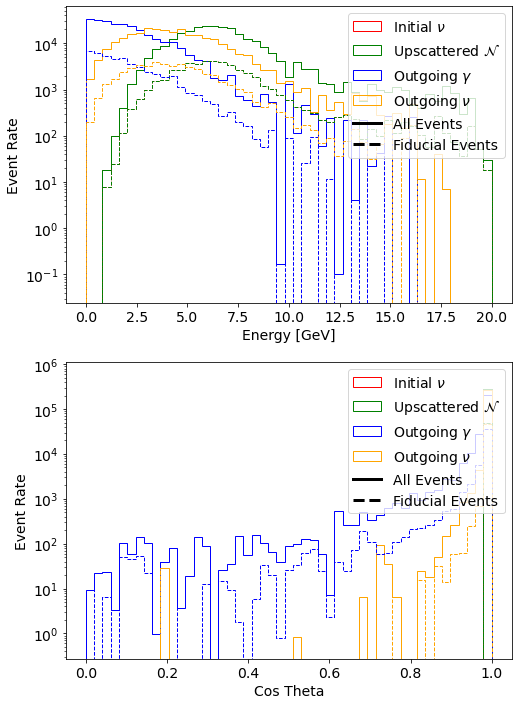

ValueError: cannot convert to RegularArray because subarray lengths are not regular (in compiled code: https://github.com/scikit-hep/awkward/blob/awkward-cpp-26/awkward-cpp/src/cpu-kernels/awkward_ListOffsetArray_toRegularArray.cpp#L22)

This error occurred while calling

    numpy.asarray(
        <Array [[[-0.561, 0.149, 2]], ..., [[...]]] type='10000 * var * var...'>
        dtype = None
    )

In [152]:
for k in filename.keys():
    data = awk.from_parquet("output/"+filename[k])
    plot_kinematics(data,POT[k],Emax[k],axis[k])
    plot_positions(data,xrange[k],yrange[k],zrange[k])